# Train Tennis Agents

## Install Requirements

In [1]:
!pip install -r requirements.txt

## Import Libraries

In [2]:
seed = 32

import torch, random
random.seed(seed)
import torch.nn as nn
torch.manual_seed(seed)

from collections import namedtuple
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
import numpy as np
np.random.seed(seed)

## Define Networks

In [3]:
class Critic(nn.Module):
    def __init__(self, n_state, n_hidden = [500, 400], n_action=0):
        super(Critic, self).__init__()
        self.n_state = n_state
        self.n_hidden = n_hidden
        self.bn1 = nn.BatchNorm1d(n_state)
        self.fc1 = nn.Linear(n_state, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0]+n_action, n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], 1)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.relu = nn.ReLU()
    def forward(self, state, action):
        x = state
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(torch.cat((x, action), dim=1)))
        x = self.fc3(x)
        return x

In [4]:
class Actor(nn.Module):
    def __init__(self, n_state, n_action, n_hidden = [500, 400]):
        super(Actor, self).__init__()
        self.n_state = n_state
        self.n_hidden = n_hidden
        self.n_action= n_action
        self.bn1 = nn.BatchNorm1d(n_state)
        self.fc1 = nn.Linear(n_state, n_hidden[0])
        self.bn2 = nn.BatchNorm1d(n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.bn3 = nn.BatchNorm1d(n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_action)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))s
        x = self.tanh(self.fc3(x))                           
        return x

## Define Replay Buffer

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):s

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = int((self.position + 1) % self.capacity)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Initialize Hyperparameters

In [7]:
replay_capacity = 1e6
lr_actor = 1e-4
lr_critic = 1e-4
weight_decay_critic = 0
discount_factor = 0.9
tau = 1e-3
batch_size = 256
noise_std_start = 0.3
noise_std_decay = 0.999
noise_std_min = 0.01
episodes = 10000
max_t = int(1e9)
n_steps = 20
iterations = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Instantiate Environment, Networks, Replay Buffer, Loss, Optimizer 

In [8]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

actor = Actor(state_size*2, action_size*2).to(device)
actor_target = Actor(state_size*2, action_size*2).to(device)
critic = Critic(state_size*2, n_action = action_size*2).to(device)
critic_target = Critic(state_size*2, n_action = action_size*2).to(device)
for target_param, param in zip(critic_target.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)
for target_param, param in zip(actor_target.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
replay_buffer = ReplayMemory(replay_capacity)
criterion = nn.MSELoss()
optim_critic = torch.optim.Adam(critic.parameters(), lr=lr_critic, weight_decay=weight_decay_critic)
optim_actor = torch.optim.Adam(actor.parameters(), lr=lr_actor)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Learn

In [8]:
scores = []
mean_loss_critic = []
mean_score_actor = []
loss_critic = []
score_actor = []
score = 0
steps = 0
noise_std = noise_std_start

for i in range(episodes):
    env_info = env.reset(train_mode=True)[brain_name]   
    state = torch.from_numpy(env_info.vector_observations).view(-1).float().to(device)
    for t in range(max_t):
        with torch.no_grad():
            actor.eval()
            action = torch.clamp(actor_target(state.unsqueeze(0))+torch.zeros((1, action_size*2)).normal_(0,noise_std).to(device),-1,1).squeeze().float()#+ ou_process.sample() 
            actor.train()
            env_info = env.step(torch.stack((action[:action_size], action[action_size:])).to('cpu').numpy())[brain_name]
            next_state = torch.from_numpy(env_info.vector_observations).view(-1).float()
            reward = torch.tensor(env_info.rewards).sum().float()
            score += reward.item()
            done = torch.tensor(env_info.local_done[0] or env_info.local_done[1]).float()
            replay_buffer.push(state.to('cpu'), action.to('cpu'), next_state, reward, done)
        if((steps+1)%n_steps==0 and len(replay_buffer)>=batch_size):
            for iteration in range(iterations):
                with torch.no_grad():  
                    sample = replay_buffer.sample(batch_size)
                    states = torch.stack([row.state for row in sample]).to(device)
                    actions = torch.stack([row.action for row in sample]).to(device)
                    rewards = torch.stack([row.reward for row in sample]).unsqueeze(1).to(device)
                    next_states = torch.stack([row.next_state for row in sample]).to(device)
                    dones = torch.stack([row.done for row in sample]).unsqueeze(1).to(device)
                    targets = rewards + (1-dones) * discount_factor * critic_target(next_states, actor_target(next_states))
                optim_critic.zero_grad()
                predictions = critic(states, actions)
                loss = criterion(predictions, targets)
                loss_critic.append(loss.item())
                loss.backward()
                optim_critic.step()
                optim_actor.zero_grad()
                loss = -critic(states, actor(states)).mean()
                score_actor.append(-loss.item())
                loss.backward()
                optim_actor.step()
                with torch.no_grad():
                    for target_param, param in zip(critic_target.parameters(), critic.parameters()):
                        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
                    for target_param, param in zip(actor_target.parameters(), actor.parameters()):
                        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
        steps += 1
        if done.item():
            break
        state = next_state.to(device)
    noise_std = max(noise_std*noise_std_decay,noise_std_min)
    if (i+1)%500==0:
        avg_score = score/500
        avg_score_actor = torch.tensor(score_actor).mean().item()
        avg_loss_critic = torch.tensor(loss_critic).mean().item()
        scores.append(avg_score)
        mean_loss_critic.append(avg_loss_critic)
        mean_score_actor.append(avg_score_actor)
        print("Episode: {}/{}, Score: {}, Score Actor: {}, Loss Critic: {}, Noise Std: {}".format(i+1, episodes, avg_score, avg_score_actor, avg_loss_critic, noise_std))
        score_actor = []
        loss_critic = []
        score = 0

Episode: 500/10000, Score: -0.007599999733269215, Score Actor: 0.02275468409061432, Loss Critic: 1.951510967046488e-05, Noise Std: 0.18191368345835565
Episode: 1000/10000, Score: -0.008999999761581421, Score Actor: 0.01745055802166462, Loss Critic: 1.0462195859872736e-05, Noise Std: 0.11030862743128944
Episode: 1500/10000, Score: -0.0033999996781349183, Score Actor: 0.006707620806992054, Loss Critic: 9.278408469981514e-06, Noise Std: 0.06688882911087081
Episode: 2000/10000, Score: 0.0054000004567205905, Score Actor: 0.010147112421691418, Loss Critic: 2.3746813894831575e-05, Noise Std: 0.040559977619249926
Episode: 2500/10000, Score: 0.010800000537186862, Score Actor: 0.01065575797110796, Loss Critic: 2.4469642085023224e-05, Noise Std: 0.024594716432354037
Episode: 3000/10000, Score: 0.016400000616908075, Score Actor: 0.009276600554585457, Loss Critic: 3.081810427829623e-05, Noise Std: 0.014913718199410881
Episode: 3500/10000, Score: 0.03238000085949898, Score Actor: 0.01004814542829990

KeyboardInterrupt: 

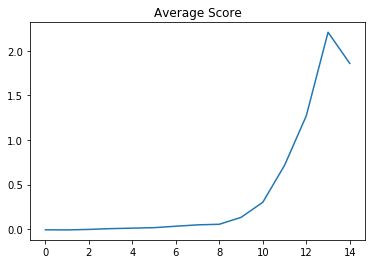

In [9]:
plt.plot(scores)
plt.title("Average Score")
plt.show()

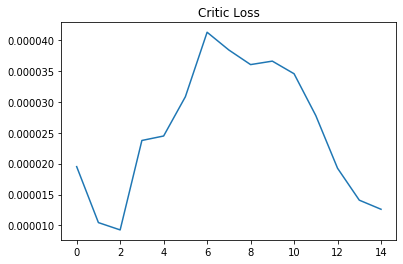

In [10]:
plt.plot(mean_loss_critic)
plt.title("Critic Loss")
plt.show()

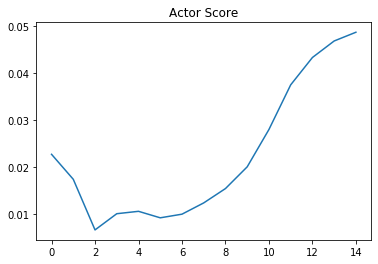

In [11]:
plt.plot(mean_score_actor)
plt.title("Actor Score")
plt.show()

In [12]:
torch.save(actor.state_dict(),"checkpoint.pth")

## Evaluate

In [9]:
actor.load_state_dict(torch.load("checkpoint.pth"))
actor.eval()

Actor(
  (bn1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=48, out_features=500, bias=True)
  (bn2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=400, bias=True)
  (bn3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=400, out_features=4, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [10]:
scores = []
score = torch.tensor([0.,0.])
episodes = 100

In [11]:
for i in tqdm_notebook(range(episodes)):
    env_info = env.reset(train_mode=True)[brain_name]   
    state = torch.from_numpy(env_info.vector_observations).view(-1).float().to(device)
    for t in range(max_t):
        with torch.no_grad():
            action = actor(state.unsqueeze(0)).squeeze().float()
            env_info = env.step(torch.stack((action[:action_size], action[action_size:])).to('cpu').numpy())[brain_name]
            next_state = torch.from_numpy(env_info.vector_observations).view(-1).float()
            reward = torch.tensor(env_info.rewards).float()
            score += reward
            done = torch.tensor(env_info.local_done[0] or env_info.local_done[1]).float()
            if done.item():
                break
            state = next_state.to(device)
    scores.append(score)
    score = torch.tensor([0.,0.]).float()

/home/moritz/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [51]:
print("Average maximum score over {} epissodes: {:.2f}".format(episodes, torch.stack([score for score in scores]).max(1)[0].mean()))

Average maximum score over 100 episodes: 1.14


## Watch Agents Play

![gif](tennis.gif)

In [12]:
score = torch.tensor([0.,0.])
episodes = 5

In [13]:
for i in range(episodes):
    env_info = env.reset(train_mode=False)[brain_name]   
    state = torch.from_numpy(env_info.vector_observations).view(-1).float().to(device)
    for t in range(max_t):
        with torch.no_grad():
            action = actor(state.unsqueeze(0)).squeeze().float()
            env_info = env.step(torch.stack((action[:action_size], action[action_size:])).to('cpu').numpy())[brain_name]
            next_state = torch.from_numpy(env_info.vector_observations).view(-1).float()
            reward = torch.tensor(env_info.rewards).float()
            score += reward
            done = torch.tensor(env_info.local_done[0] or env_info.local_done[1]).float()
            if done.item():
                break
            state = next_state.to(device)
    print("Scores: {}".format(score.tolist()))
    score = torch.tensor([0.,0.]).float()

Scores: [0.2900000214576721, 0.4000000059604645]
Scores: [2.200000047683716, 2.0900001525878906]
Scores: [0.9000000953674316, 0.7900000810623169]
Scores: [2.299999952316284, 2.2899999618530273]
Scores: [2.5999996662139893, 2.499999761581421]
